# Notebook 3: Single Model Evaluation on Test Set

**Goal:**
1.  Evaluate a single best trained model (from Notebook 2: `02_Final_Training.ipynb`) on the test set.
2.  Generate predictions for each image in the test set.
3.  Calculate and display detailed performance metrics, including a classification report and confusion matrix.
4.  Save the predictions and evaluation metrics for later use (e.g., in comparative analysis).

**Setup for this Run:**
*   **Model:** [Specify e.g., ResNet, matching a completed Notebook 2 run]
*   **Unfreeze Strategy:** [Specify e.g., 'mid']
*   **Data Augmentation (during training):** [Specify e.g., True/False]
*   **Best Model Weights:** Loaded from file generated by Notebook 2.

This notebook focuses on the detailed evaluation of *one specific experimental setup*. Comparative analysis across multiple setups will be done in `04_Comparative_Analysis.ipynb`.

In [1]:
import torch
import torch.nn as nn
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm # For progress bars

# Import utility functions
import utils

# --- Define Setup for SINGLE Model Evaluation (initially) ---
# This should match a *completed* training run from Notebook 2

# Unique identifier for the experimental setup to evaluate
SETUP_ID_TO_EVAL = 'resnet_mid_noaug' # <<< CHANGE THIS TO THE DESIRED SETUP ID >>>

MODEL_NAME = 'resnet'        # 'resnet' or 'mobilenet' (must match SETUP_ID_TO_EVAL)
UNFREEZE_STRATEGY = 'mid'    # 'head', 'mid', or 'deep' (must match SETUP_ID_TO_EVAL)

# --- Device Setup ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# --- Unfreeze Strategy Mapping ---
resnet_unfreeze_map = { # Renamed to match MODEL_NAME
    'head': ['fc.'],
    'mid':  ['fc.', 'layer4.'],
    'deep': ['fc.', 'layer4.', 'layer3.']
}
mobilenet_unfreeze_map = { # Renamed to match MODEL_NAME
    'head': ['classifier.3.'],
    'mid':  ['classifier.3.', 'features.10.', 'features.11.', 'features.12.'],
    'deep': ['classifier.3.', 'features.8.', 'features.9.', 'features.10.', 'features.11.', 'features.12.']
}
if MODEL_NAME == 'resnet':
    layers_to_unfreeze = resnet_unfreeze_map[UNFREEZE_STRATEGY]
elif MODEL_NAME == 'mobilenet':
    layers_to_unfreeze = mobilenet_unfreeze_map[UNFREEZE_STRATEGY]

# --- Filenames ---
best_model_filename = f"best_model_{SETUP_ID_TO_EVAL}.pth"
predictions_filename = f"predictions_{SETUP_ID_TO_EVAL}.csv"
eval_metrics_filename = f"eval_metrics_{SETUP_ID_TO_EVAL}.csv"

print(f"Evaluating Setup ID: {SETUP_ID_TO_EVAL}")
print(f"Model: {MODEL_NAME}, Unfreeze: {UNFREEZE_STRATEGY}")

Using device: mps
Evaluating Setup ID: resnet_mid_noaug
Model: resnet, Unfreeze: mid


In [2]:
# 1. Instantiate Model Architecture
model = utils.get_model(MODEL_NAME) # get_model now only returns model
model = utils.adapt_model_head(model, MODEL_NAME)
model = utils.apply_unfreeze_logic(model, layers_to_unfreeze)
print(f"Model '{MODEL_NAME}' architecture instantiated for evaluation.")

# 2. Load Saved Best Model Weights
print(f"Loading best model weights from: {best_model_filename}")
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.to(device)
model.eval() # Set to evaluation mode
print("Best model weights loaded and model set to evaluation mode.")

Model 'resnet' architecture instantiated for evaluation.
Loading best model weights from: best_model_resnet_mid_noaug.pth
Best model weights loaded and model set to evaluation mode.


/var/folders/br/143tjw8148nftd61z3w9qzv40000gp/T/ipykernel_994/664396850.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_file

In [3]:
# 3. Load Test Dataset 
test_dataset = utils.get_datasets(task='test')
print(f"Test Dataset loaded with {len(test_dataset)} images.")


# Get class names (assuming OxfordIIITPet structure)
if hasattr(test_dataset, '_breeds'): # OxfordIIITPet specific attribute
    class_names = test_dataset._breeds
elif hasattr(test_dataset, 'classes'): # Generic torchvision dataset attribute
    class_names = test_dataset.classes
else: # Fallback if class names are not directly accessible
    class_names = [str(i) for i in range(utils.NUM_CLASSES)]
print(f"Number of classes: {len(class_names)}")

Test Dataset loaded with 3669 images.
Number of classes: 37


In [4]:
print("Generating predictions on the test set (iterating directly over dataset)...")
all_predictions = []
all_true_labels = []
# Image indices will just be 0 to len(test_dataset)-1

with torch.no_grad():
    # Iterate directly over the dataset
    for i in tqdm(range(len(test_dataset)), desc="Testing"):
        image, true_label = test_dataset[i] # Get image and label

        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(device) # Add batch dimension for single image
        # label is already a scalar

        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

        all_predictions.append(predicted_class.item()) # Get scalar value
        all_true_labels.append(true_label)

# Store predictions in a more structured format
prediction_results = []
for i, (true_label, pred_label) in enumerate(zip(all_true_labels, all_predictions)):
    prediction_results.append({
        'image_id': i, # Simple index
        'true_label_idx': int(true_label),
        'predicted_label_idx': int(pred_label),
        'true_label_name': class_names[int(true_label)],
        'predicted_label_name': class_names[int(pred_label)]
    })

print(f"Predictions generated for {len(prediction_results)} test images.")

Generating predictions on the test set (iterating directly over dataset)...


Testing:   0%|          | 0/3669 [00:00<?, ?it/s]

Predictions generated for 3669 test images.


In [5]:
# Save predictions to csv
predictions_df = pd.DataFrame(prediction_results)
predictions_df.to_csv(predictions_filename, index=False)
print(f"Predictions saved to: {predictions_filename}")

Predictions saved to: predictions_resnet_mid_noaug.csv


In [6]:
print(f"\n--- Evaluation Metrics for Setup: {SETUP_ID_TO_EVAL} ---")

y_true = np.array(all_true_labels)
y_pred = np.array(all_predictions)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0, output_dict=True)
print("\nClassification Report:")

# get accuracy and remove from the report
total_accuracy = report['accuracy']
print(f"\nOverall Test Accuracy: {total_accuracy * 100:.2f}%")
del report['accuracy'] 

# convert to DataFrame and make it more readable
report_df = pd.DataFrame(report).T
# convert to percentage with 2 decimal places
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].apply(lambda x: x * 100).round(2)
# Convert support to int
report_df['support'] = report_df['support'].astype(int) 

# save to csv
report_df.to_csv(eval_metrics_filename)
print(f"Evaluation metrics saved to: {eval_metrics_filename}")

report_df


--- Evaluation Metrics for Setup: resnet_mid_noaug ---

Classification Report:

Overall Test Accuracy: 84.76%
Evaluation metrics saved to: eval_metrics_resnet_mid_noaug.csv


,precision,recall,f1-score,support
Abyssinian,74.78,87.76,80.75,98
American Bulldog,84.75,50.00,62.89,100
American Pit Bull Terrier,55.56,60.00,57.69,100
Basset Hound,94.57,87.00,90.62,100
Beagle,80.19,85.00,82.52,100
Bengal,93.88,46.00,61.74,100
Birman,83.54,66.00,73.74,100
Bombay,83.00,94.32,88.30,88
Boxer,57.41,93.94,71.26,99
British Shorthair,87.10,81.00,83.94,100


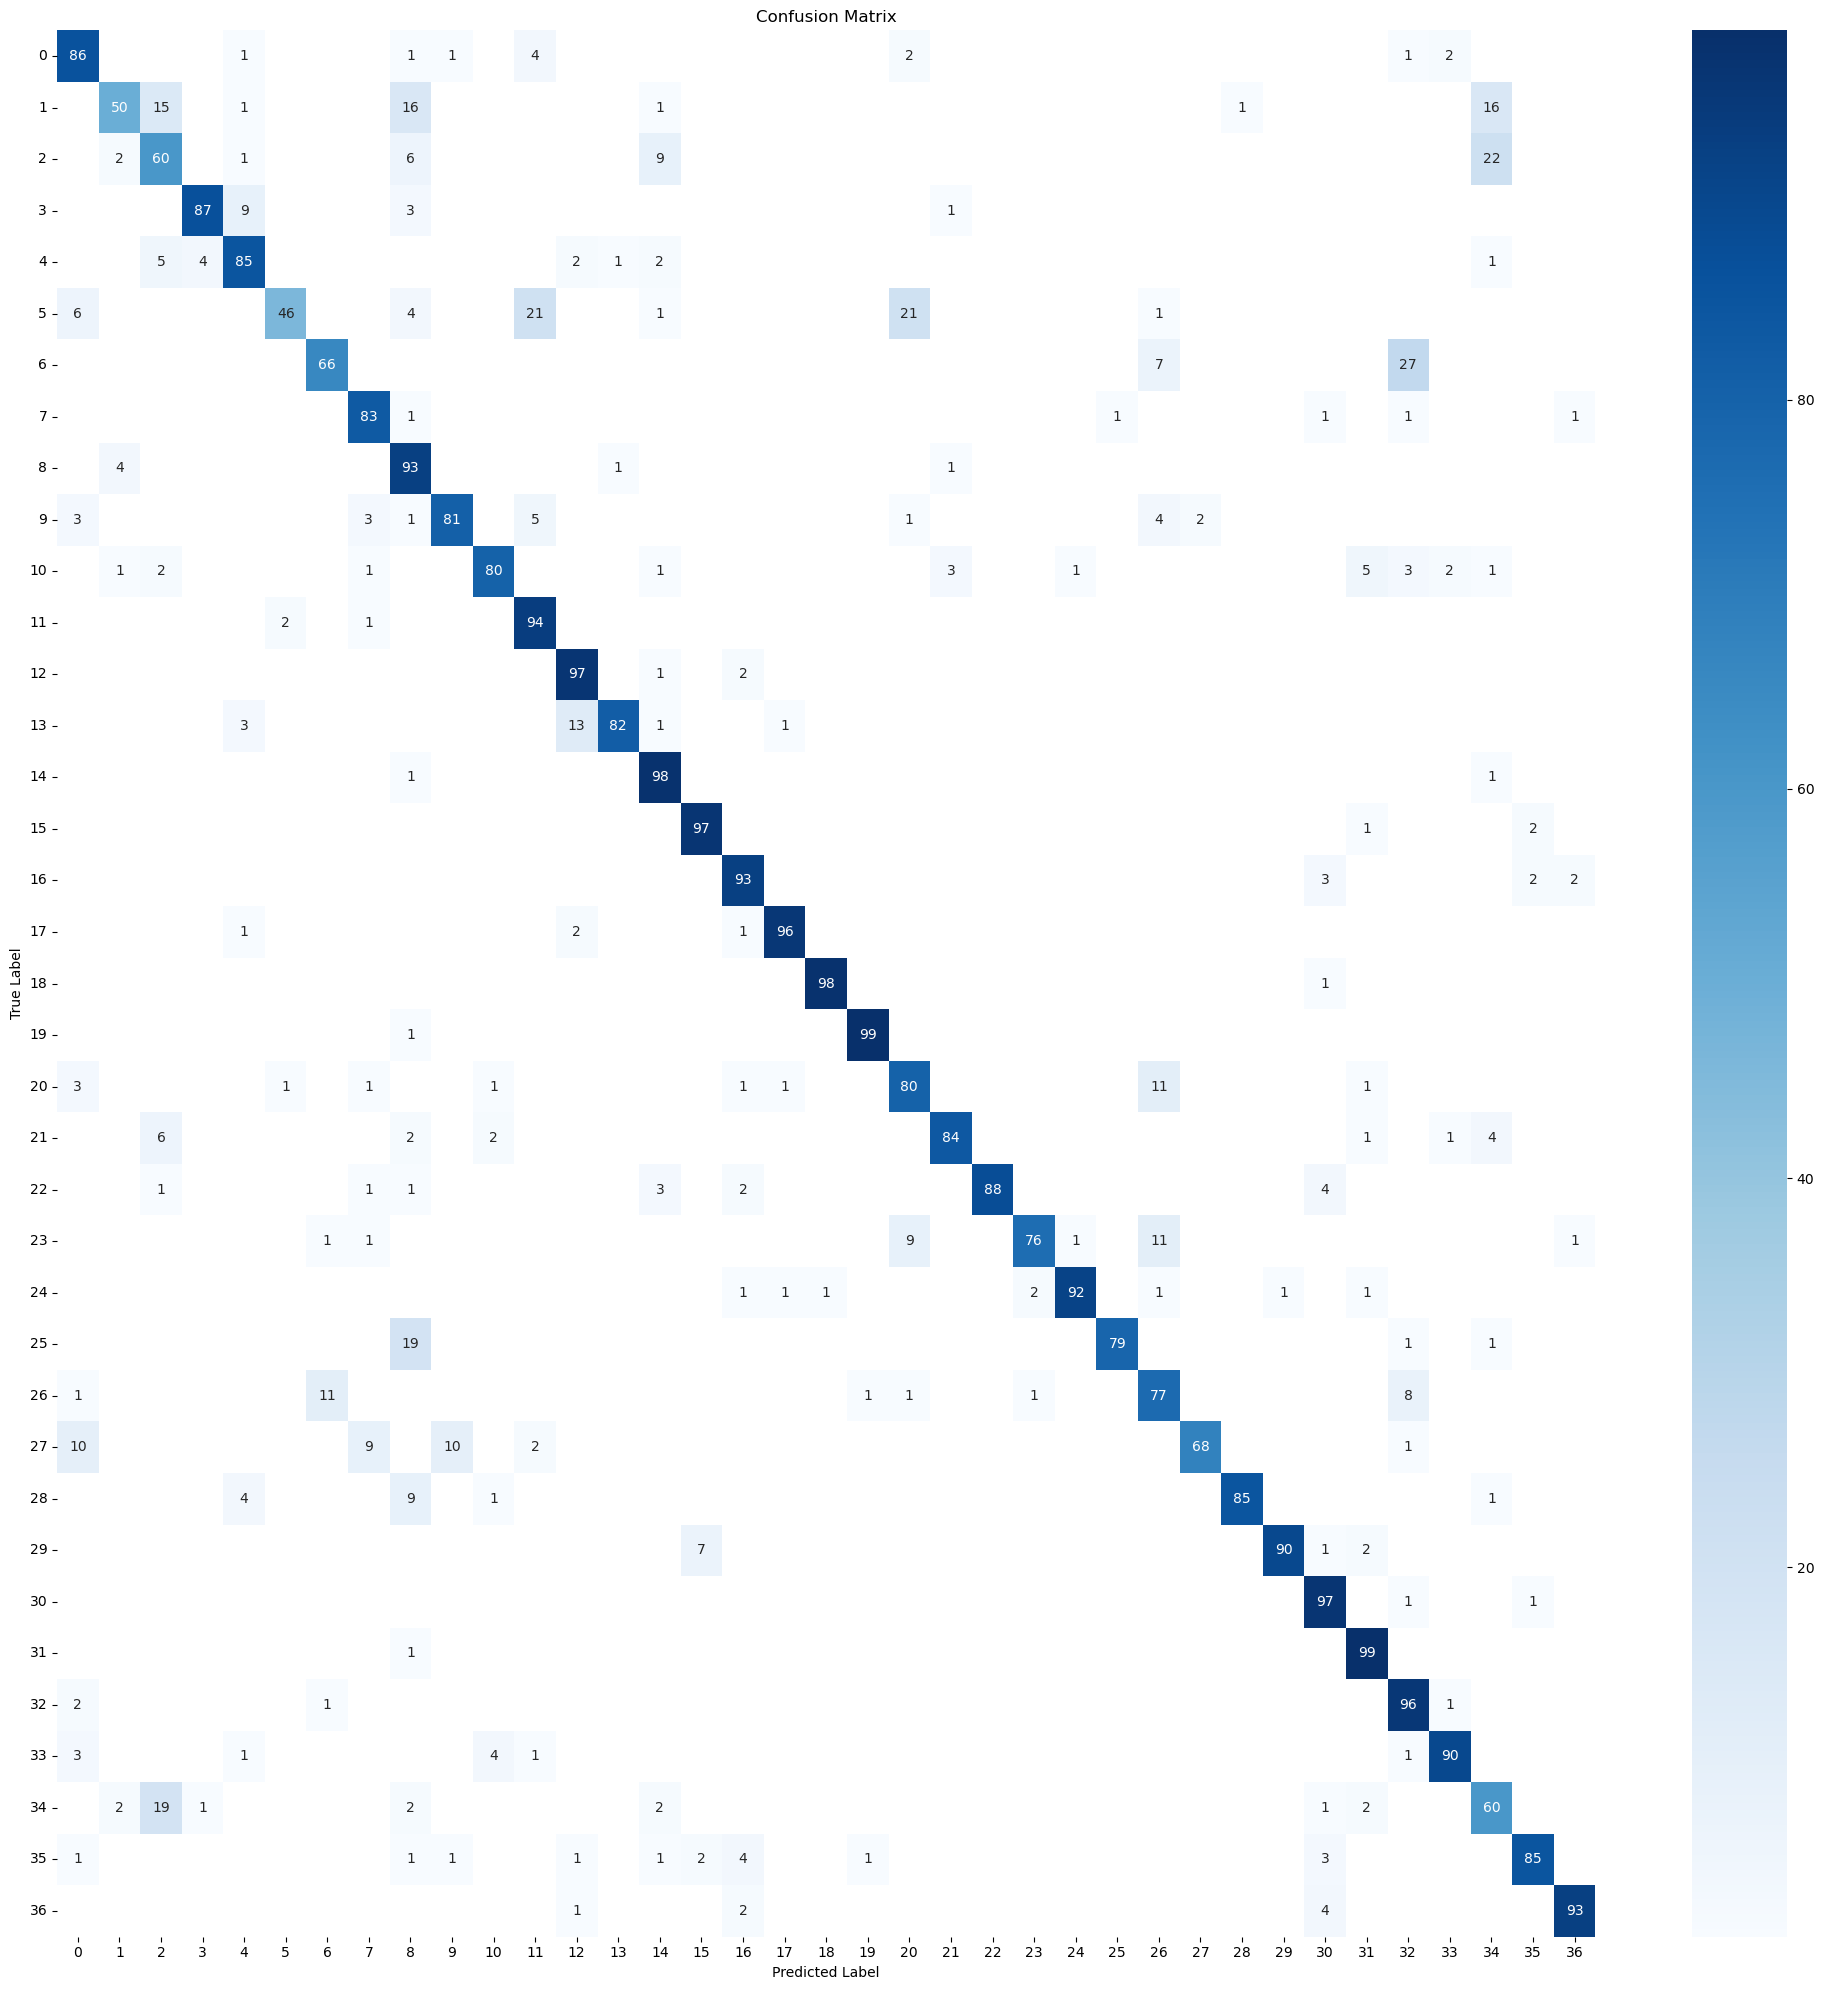

In [7]:
# Confusion Matrix; uses label indices instead of names
cm = confusion_matrix(y_true, y_pred)
mask = (cm == 0)  # Mask cells where value is 0
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, mask=mask)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()